In [0]:
import numpy as np
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [58]:
#Start with 4-PAM - n=1, k=2
n = 1
k = 2
M = 2**k
R = k/n
training_noise_ratio = 10**0.7
noise_mag = np.sqrt(1/(2*R*training_noise_ratio))
print(noise_mag)

0.22334179607548157


In [59]:
dat_size=M*10000
rand_data=np.random.randint(M,size=dat_size)
xs = keras.utils.to_categorical(rand_data)
print('verification checks:')
print(xs[2],'\n',xs[20],'\n',xs[200])


verification checks:
[1. 0. 0. 0.] 
 [0. 0. 1. 0.] 
 [0. 1. 0. 0.]


In [60]:
#input
autoenc_in = keras.layers.Input(shape=(M,))
#encoder
encoder_0 = keras.layers.Dense(M,activation='relu')(autoenc_in)
encoder_1 = keras.layers.Dense(n,activation='linear')(encoder_0)
#Regulariser
regulariser = keras.layers.BatchNormalization(center=False,scale=False)(encoder_1)
#Channel
channel = keras.layers.GaussianNoise(noise_mag)(regulariser)
#decoder
decoder_0 = keras.layers.Dense(M,activation='relu')(channel)
decoder_1 = keras.layers.Dense(M,activation='softmax')(decoder_0)
#whole model
autoenc = keras.models.Model(autoenc_in,decoder_1)
print (autoenc.summary())

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 4)]               0         
_________________________________________________________________
dense_24 (Dense)             (None, 4)                 20        
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 5         
_________________________________________________________________
batch_normalization_6 (Batch (None, 1)                 2         
_________________________________________________________________
gaussian_noise_6 (GaussianNo (None, 1)                 0         
_________________________________________________________________
dense_26 (Dense)             (None, 4)                 8         
_________________________________________________________________
dense_27 (Dense)             (None, 4)                 20 

In [0]:
#learning rate and compiling
adam = keras.optimizers.Adam(learning_rate=0.0003)
autoenc.compile(optimizer=adam, loss='categorical_crossentropy')

In [62]:
autoenc.fit(xs,xs,batch_size=M*100,epochs=250)

Epoch 1/250
100/100 [==============================] - 0s 1ms/step - loss: 1.5453
Epoch 2/250
100/100 [==============================] - 0s 1ms/step - loss: 1.4728
Epoch 3/250
100/100 [==============================] - 0s 1ms/step - loss: 1.3938
Epoch 4/250
100/100 [==============================] - 0s 1ms/step - loss: 1.2624
Epoch 5/250
100/100 [==============================] - 0s 1ms/step - loss: 1.1395
Epoch 6/250
100/100 [==============================] - 0s 1ms/step - loss: 1.0563
Epoch 7/250
100/100 [==============================] - 0s 1ms/step - loss: 0.9945
Epoch 8/250
100/100 [==============================] - 0s 1ms/step - loss: 0.9458
Epoch 9/250
100/100 [==============================] - 0s 1ms/step - loss: 0.9035
Epoch 10/250
100/100 [==============================] - 0s 1ms/step - loss: 0.8676
Epoch 11/250
100/100 [==============================] - 0s 1ms/step - loss: 0.8355
Epoch 12/250
100/100 [==============================] - 0s 1ms/step - loss: 0.8065
Epoch 13/250


In [0]:
#define sub-models with identical parameters:
encoder = keras.models.Model(autoenc_in,regulariser)
deco_in = keras.layers.Input(shape=(n,))
deco = autoenc.layers[-2](deco_in)
deco = autoenc.layers[-1](deco)
decoder = keras.models.Model(deco_in,deco)

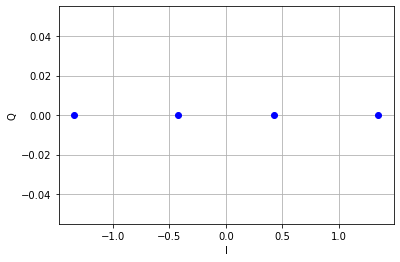

In [64]:
#Plot the encoder's points
data = []
for i in range(0,M):
  temp = np.zeros(M)
  temp[i] = 1
  data.append(encoder.predict(np.expand_dims(temp,axis=0)))
data = np.array(data)
data = np.squeeze(data)
plt.plot(data,np.zeros(M),'bo')
plt.grid()
plt.xlabel('I')
plt.ylabel('Q')
plt.show()

In [65]:
#Calculate expected power usage (for equal usage of each symbol)
power_use=0
for iter1 in np.arange(M):
    symbol_energy=data[iter1]**2
    print("symbol X:",data[iter1],"\n symbol energy=",symbol_energy)
    power_use += symbol_energy/M
print(power_use)
scaling=np.sqrt(power_use)

symbol X: -0.42254508 
 symbol energy= 0.17854434075879055
symbol X: 0.42843875 
 symbol energy= 0.18355976497762416
symbol X: 1.3527187 
 symbol energy= 1.8298479108172074
symbol X: -1.3466824 
 symbol energy= 1.81355356542214
1.0013763954939405


In [67]:
#Plot error rate
EbNo_range_dB = list(np.arange(0,16,1.5))
ber= [None]*len(EbNo_range_dB)
for iter1 in range(len(EbNo_range_dB)):
    EbNo = 10**(EbNo_range_dB[iter1]/10.0)
    noise_std = np.sqrt(1/(2*R*EbNo))
    noise = noise_std*np.random.randn(dat_size,n)
    sig_in = encoder.predict(xs) + noise
    prediction = decoder.predict(sig_in)
    prediction = np.argmax(prediction,axis=1)
    wrong = (prediction != rand_data)
    count = np.sum(wrong)
    ber[iter1] = count/dat_size
    print('EbNo(dB):',EbNo_range_dB[iter1],'SER',ber[iter1])


EbNo(dB): 0.0 SER 0.2762
EbNo(dB): 1.5 SER 0.208575
EbNo(dB): 3.0 SER 0.150025
EbNo(dB): 4.5 SER 0.09945
EbNo(dB): 6.0 SER 0.055875
EbNo(dB): 7.5 SER 0.024475
EbNo(dB): 9.0 SER 0.008375
EbNo(dB): 10.5 SER 0.002225
EbNo(dB): 12.0 SER 0.000325
EbNo(dB): 13.5 SER 0.0
EbNo(dB): 15.0 SER 0.0
